# Multiclass Classification (Rock|Paper|Scissors)

## Preparing Data

In [1]:
# !wget --no-check-certificate \
# https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
#     -O Dataset/rock_paper_scissors_train.zip
    
    
# !wget --no-check-certificate \
# https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
#     -O Dataset/rock_paper_scissors_test.zip

In [3]:
import os
import zipfile

DATASET_DIR = 'Dataset'
DATASET_ZIP_TRAIN = 'Dataset/rock_paper_scissors_train.zip'
DATASET_ZIP_TEST = 'Dataset/rock_paper_scissors_test.zip'
BASE_DIR = 'Dataset/rps'
DATASET_TRAIN_DIR = 'Dataset/rps/train'
DATASET_TEST_DIR = 'Dataset/rps/test'

if not os.path.isdir(BASE_DIR):
    os.makedirs(DATASET_TRAIN_DIR)
    os.makedirs(DATASET_TEST_DIR)
    
    with zipfile.ZipFile(DATASET_ZIP_TRAIN, 'r') as zipref:
        zipref.extractall(DATASET_TRAIN_DIR)
        
    with zipfile.ZipFile(DATASET_ZIP_TEST, 'r') as zipref:
        zipref.extractall(DATASET_TEST_DIR)
        
os.listdir(BASE_DIR)

['train', 'test']

In [4]:
def total_count(DIR):
    cat = DIR.split('/')[-1]
    print(f"Total number of data in *{cat}* is: {len(os.listdir(DIR))}")

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'test')

TRAIN_ROCK_DIR = os.path.join(TRAIN_DIR, 'rock')
total_count(TRAIN_ROCK_DIR)
VALID_ROCK_DIR = os.path.join(VALID_DIR, 'rock')
total_count(VALID_ROCK_DIR)

TRAIN_PAPER_DIR = os.path.join(TRAIN_DIR, 'paper')
total_count(TRAIN_PAPER_DIR)
VALID_PAPER_DIR = os.path.join(VALID_DIR, 'paper')
total_count(VALID_PAPER_DIR)

TRAIN_SCI_DIR = os.path.join(TRAIN_DIR, 'scissors')
total_count(TRAIN_SCI_DIR)
VALID_SCI_DIR = os.path.join(VALID_DIR, 'scissors')
total_count(VALID_SCI_DIR)

Total number of data in *rock* is: 840
Total number of data in *rock* is: 124
Total number of data in *paper* is: 840
Total number of data in *paper* is: 124
Total number of data in *scissors* is: 840
Total number of data in *scissors* is: 124


## Visualizing Examples

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_samples(img_dir, rows=3, cols=3):
    plt.figure()
    f, axs = plt.subplots(rows, cols, figsize=(12, 10))
    for i in range(rows):
        for j in range(cols):
            img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
            img = plt.imread(img_path)
            axs[i, j].title.set_text(img_dir.split('/')[-1])
            axs[i, j].imshow(img)

<Figure size 432x288 with 0 Axes>

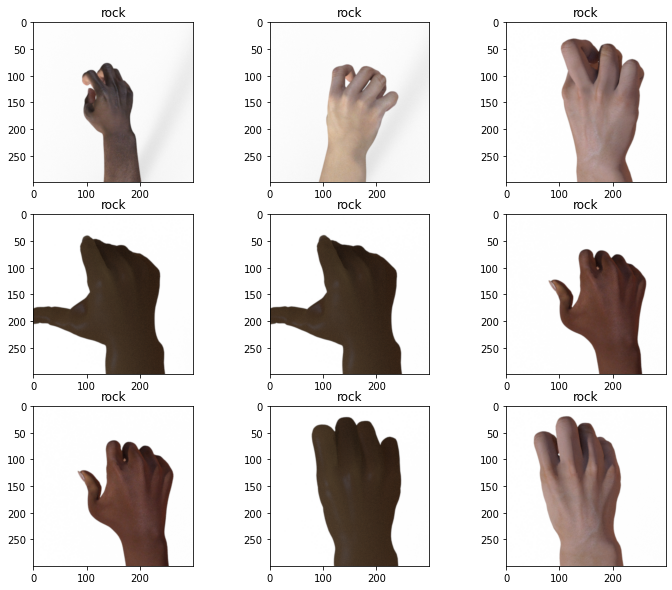

In [6]:
plot_samples(TRAIN_ROCK_DIR)

<Figure size 432x288 with 0 Axes>

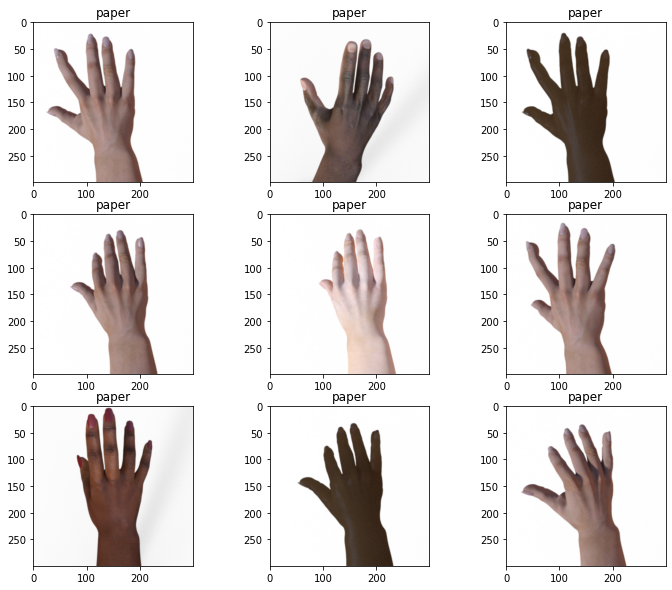

In [7]:
plot_samples(TRAIN_PAPER_DIR)

<Figure size 432x288 with 0 Axes>

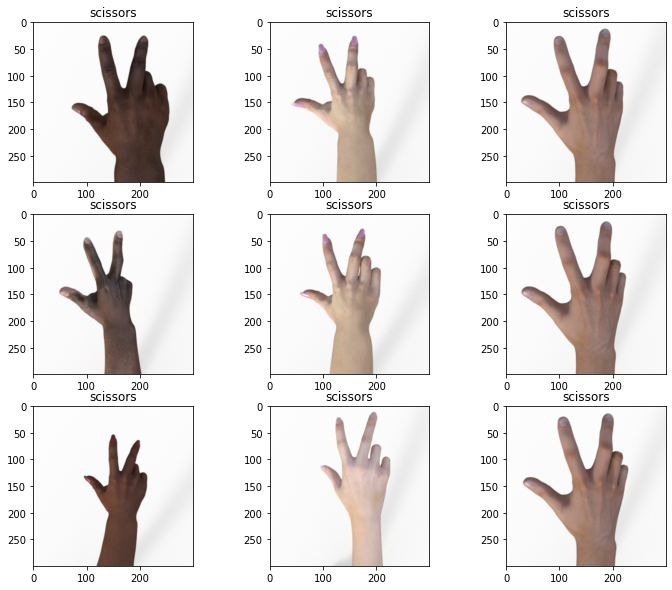

In [8]:
plot_samples(TRAIN_SCI_DIR)

## Build Model

In [9]:
import tensorflow as tf

In [10]:
def MULTI_CLASSIFIER_MODEL():
    ## Building
    inputs = tf.keras.Input(shape=(150,150,3))
    x1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(inputs)
    x2 = tf.keras.layers.MaxPool2D((2,2))(x1)
    x3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x2)
    x4 = tf.keras.layers.MaxPool2D((2,2))(x3)
    x5 = tf.keras.layers.Flatten()(x4)
    x6 = tf.keras.layers.Dense(256, activation='relu')(x5)
    x7 = tf.keras.layers.Dense(128, activation='relu')(x6)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x7)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs) 

    return model

In [12]:
## Model
model = MULTI_CLASSIFIER_MODEL()
## Compiling Model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 165888)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4246

## Image Generators

In [14]:
## Data Augemntation
TRAIN_DATA_GENERATOR = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                       rotation_range=20,
                                                                       width_shift_range=20,
                                                                      height_shift_range=20,
                                                                       shear_range=20,
                                                                       zoom_range=10,
                                                                       fill_mode='nearest')

VALID_DATA_GENERATOR = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [15]:
TRAIN_DATA_GEN = TRAIN_DATA_GENERATOR.flow_from_directory(
                    TRAIN_DIR,
                    target_size=(150,150),
                    color_mode='rgb',
                    class_mode='categorical',
                    batch_size=32,
                    shuffle=True,
                    seed=123
            )

VALID_DATA_GEN = VALID_DATA_GENERATOR.flow_from_directory(
                    VALID_DIR,
                    target_size=(150,150),
                    color_mode='rgb',
                    class_mode='categorical',
                    batch_size=32,
                    shuffle=False,
                    seed=123
            )

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## Early Stopping

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='acc', patience=5, verbose=1, restore_best_weights=True
                )

In [23]:
history = model.fit(
            TRAIN_DATA_GEN,
            batch_size=20,
            epochs=40,
            verbose=1,
            callbacks=[early_stopping],
            validation_data=VALID_DATA_GEN
            )

Epoch 1/40
79/79 [==============================] - 53s 670ms/step - loss: 1.1439 - acc: 0.4425 - val_loss: 1.0610 - val_acc: 0.4086
Epoch 2/40
79/79 [==============================] - 56s 713ms/step - loss: 1.0284 - acc: 0.4722 - val_loss: 1.0858 - val_acc: 0.3091
Epoch 3/40
79/79 [==============================] - 56s 709ms/step - loss: 0.9775 - acc: 0.5381 - val_loss: 1.0786 - val_acc: 0.3629
Epoch 4/40
79/79 [==============================] - 56s 702ms/step - loss: 0.8543 - acc: 0.5956 - val_loss: 1.1382 - val_acc: 0.3280
Epoch 5/40
79/79 [==============================] - 53s 667ms/step - loss: 0.8030 - acc: 0.6210 - val_loss: 1.2400 - val_acc: 0.3468
Epoch 6/40
79/79 [==============================] - 52s 661ms/step - loss: 0.7657 - acc: 0.6603 - val_loss: 1.1848 - val_acc: 0.3629
Epoch 7/40
79/79 [==============================] - 53s 664ms/step - loss: 0.7225 - acc: 0.6909 - val_loss: 1.0825 - val_acc: 0.5430
Epoch 8/40
79/79 [==============================] - 53s 666ms/step - 

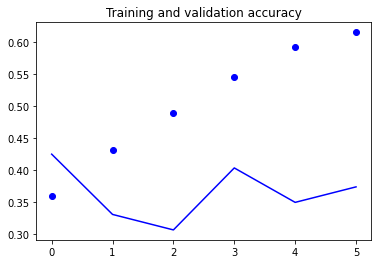

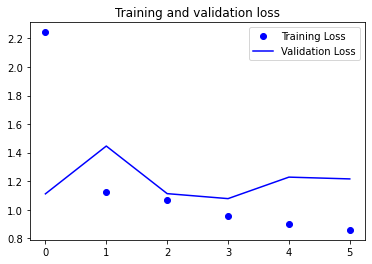

In [19]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, 'bo', label='training accuracy')
plt.plot  ( epochs, val_acc, 'b', label='validation accuracy')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, 'bo', label='Training Loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation Loss')
plt.title ('Training and validation loss')
plt.legend()

## Inference

In [26]:
def predict_image(image_path):
    image = tf.keras.preprocessing.image.load_img(
            image_path, color_mode='rgb', target_size=(150,150))
    
    image_array = np.asarray(image)
    image_array = np.expand_dims(image_array, axis=0)
    out = model.predict(image_array)
    print(out)
    

In [31]:
test_img_path = "Dataset/rps/train/paper/paper01-001.png"
predict_image(test_img_path)

[[1. 0. 0.]]
